In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from pathlib import Path
import time, os

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"✅ Using device: {device}")
if device.type == "cuda":
    print(f"   GPU: {torch.cuda.get_device_name(0)}")


✅ Using device: cuda
   GPU: NVIDIA GeForce RTX 4050 Laptop GPU


In [2]:
data_split_dir = Path("../data/splits")

# Transforms
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Datasets
train_dataset = datasets.ImageFolder(root=data_split_dir / "train", transform=train_transforms)
val_dataset   = datasets.ImageFolder(root=data_split_dir / "val", transform=val_transforms)

# Dataloaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4, pin_memory=True)
val_loader   = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4, pin_memory=True)

num_classes = len(train_dataset.classes)
print(f"✅ Dataset ready with {num_classes} classes")


✅ Dataset ready with 38 classes


In [3]:
model = models.resnet50(pretrained=True)

# Freeze base layers
for param in model.parameters():
    param.requires_grad = False

# Replace classifier
model.fc = nn.Sequential(
    nn.Linear(2048, 512),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(512, num_classes)
)

model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)

print("✅ Model ready for training")


d:\Software\Anaconda\envs\pytorch-gpu\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\Software\Anaconda\envs\pytorch-gpu\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


✅ Model ready for training


In [4]:
checkpoint_dir = "../models/checkpoints"
os.makedirs(checkpoint_dir, exist_ok=True)

def save_checkpoint(model, optimizer, epoch, best_acc, filename):
    state = {
        "epoch": epoch,
        "model_state": model.state_dict(),
        "optimizer_state": optimizer.state_dict(),
        "best_acc": best_acc
    }
    torch.save(state, filename)

def load_checkpoint(model, optimizer, filename):
    checkpoint = torch.load(filename, map_location=device)
    model.load_state_dict(checkpoint["model_state"])
    optimizer.load_state_dict(checkpoint["optimizer_state"])
    start_epoch = checkpoint["epoch"] + 1
    best_acc = checkpoint["best_acc"]
    print(f"✅ Loaded checkpoint from epoch {checkpoint['epoch']}, best_acc={best_acc:.4f}")
    return model, optimizer, start_epoch, best_acc


In [5]:
import matplotlib.pyplot as plt

def train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=10, resume=False):
    best_acc = 0.0
    start_epoch = 0
    history = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []}

    latest_ckpt = os.path.join(checkpoint_dir, "latest.pth")

    # Resume if requested
    if resume and os.path.exists(latest_ckpt):
        model, optimizer, start_epoch, best_acc = load_checkpoint(model, optimizer, latest_ckpt)

    for epoch in range(start_epoch, num_epochs):
        start_time = time.time()

        # --- Training ---
        model.train()
        running_loss, running_corrects = 0.0, 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            _, preds = torch.max(outputs, 1)
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = running_corrects.double() / len(train_loader.dataset)
        history["train_loss"].append(epoch_loss)
        history["train_acc"].append(epoch_acc.item())

        # --- Validation ---
        model.eval()
        val_loss, val_corrects = 0.0, 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                _, preds = torch.max(outputs, 1)
                val_loss += loss.item() * inputs.size(0)
                val_corrects += torch.sum(preds == labels.data)

        val_loss /= len(val_loader.dataset)
        val_acc = val_corrects.double() / len(val_loader.dataset)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc.item())

        # Save best model
        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), "../models/best_resnet50.pth")

        # Save checkpoint (per epoch)
        ckpt_name = os.path.join(checkpoint_dir, f"epoch_{epoch+1}.pth")
        save_checkpoint(model, optimizer, epoch, best_acc, ckpt_name)

        # Update latest checkpoint
        save_checkpoint(model, optimizer, epoch, best_acc, latest_ckpt)

        elapsed = time.time() - start_time
        print(f"\n📌 Epoch {epoch+1}/{num_epochs}")
        print(f"   🔹 Train Loss: {epoch_loss:.4f} | Train Acc: {epoch_acc:.4f}")
        print(f"   🔹 Val Loss:   {val_loss:.4f} | Val Acc:   {val_acc:.4f}")
        print(f"   ⏱️ Time: {elapsed:.1f}s")

    # Save final model
    torch.save(model.state_dict(), "../models/final_resnet50.pth")

    print(f"\n✅ Training complete. Best Val Acc: {best_acc:.4f}")

    # --- Plot results ---
    plt.figure(figsize=(12,5))

    # Loss curve
    plt.subplot(1,2,1)
    plt.plot(history["train_loss"], label="Train Loss")
    plt.plot(history["val_loss"], label="Val Loss")
    plt.xlabel("Epochs"); plt.ylabel("Loss")
    plt.title("Loss Curve"); plt.legend()

    # Accuracy curve
    plt.subplot(1,2,2)
    plt.plot(history["train_acc"], label="Train Acc")
    plt.plot(history["val_acc"], label="Val Acc")
    plt.xlabel("Epochs"); plt.ylabel("Accuracy")
    plt.title("Accuracy Curve"); plt.legend()

    plt.show()

    return model, history



📌 Epoch 1/10
   🔹 Train Loss: 0.8444 | Train Acc: 0.7547
   🔹 Val Loss:   0.3307 | Val Acc:   0.8987
   ⏱️ Time: 225.2s

📌 Epoch 2/10
   🔹 Train Loss: 0.4745 | Train Acc: 0.8440
   🔹 Val Loss:   0.2557 | Val Acc:   0.9220
   ⏱️ Time: 223.8s

📌 Epoch 3/10
   🔹 Train Loss: 0.4260 | Train Acc: 0.8595
   🔹 Val Loss:   0.2555 | Val Acc:   0.9151
   ⏱️ Time: 224.2s

📌 Epoch 4/10
   🔹 Train Loss: 0.4114 | Train Acc: 0.8648
   🔹 Val Loss:   0.2211 | Val Acc:   0.9251
   ⏱️ Time: 230.2s

📌 Epoch 5/10
   🔹 Train Loss: 0.3859 | Train Acc: 0.8747
   🔹 Val Loss:   0.2179 | Val Acc:   0.9267
   ⏱️ Time: 224.0s

📌 Epoch 6/10
   🔹 Train Loss: 0.3551 | Train Acc: 0.8850
   🔹 Val Loss:   0.2278 | Val Acc:   0.9240
   ⏱️ Time: 231.4s

📌 Epoch 7/10
   🔹 Train Loss: 0.3551 | Train Acc: 0.8828
   🔹 Val Loss:   0.1802 | Val Acc:   0.9408
   ⏱️ Time: 240.0s

📌 Epoch 8/10
   🔹 Train Loss: 0.3432 | Train Acc: 0.8888
   🔹 Val Loss:   0.1663 | Val Acc:   0.9445
   ⏱️ Time: 228.5s

📌 Epoch 9/10
   🔹 Train Loss: 0

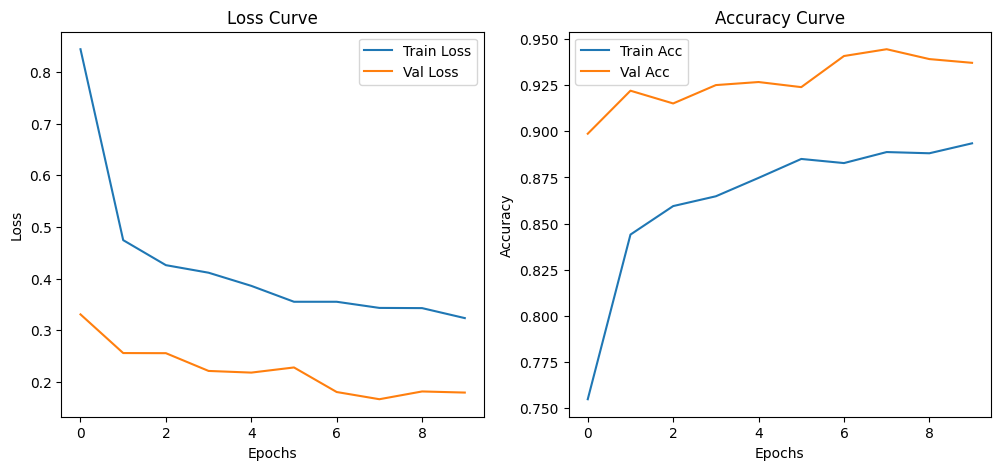

In [6]:

trained_model, history = train_model(
    model,
    criterion,
    optimizer,
    train_loader,
    val_loader,
    num_epochs=10,
    resume=True  # set true if checkpoint exists..
)
